In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt

import scipy
from scipy import signal,stats
from scipy.fft import rfft,rfftfreq
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.signal import decimate

import seaborn as sns
import pandas as pd
import sklearn
import seaborn as sns

from awear_function_lib import load_eeg_data, apply_filters, plot_psd, plot_ratios_bar, calculate_ratios
from awear_function_lib import plot_spectrogram, plot_band_ratios_spectrogram, plot_band_ratios_box_whisker, plot_band_ratio_heatmap, plot_avg_power_heatmap
from awear_function_lib import remove_outliers, compute_time_resolved_pac, compute_effect_sizes
from awear_function_lib import compute_sample_entropy, compute_approximate_entropy, compute_average_entropy, compute_anova_entropy, compute_pairwise_tests

import itertools
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

import importlib
import awear_function_lib
importlib.reload(awear_function_lib) 

In [ ]:
# Define file paths and labels, load data
file_paths = [
    '.../1_250124_205115-210602_brainwaves - Antonio - LVHA - Horror movies.txt',
    '.../2_250124_210834-212527_brainwaves - Antonio - HVLA - Vipassana.txt',
    '.../3_250124_225258-230511_brainwaves - Antonio - HVLA - Vipassana after hot tub.txt'
]

# file_paths = [
#     '.../Filtered and Sectioned Data/horror_movie_data_filtered.txt',
#     '.../Filtered and Sectioned Data/vipassana_data_filtered.txt',
#     '.../Filtered and Sectioned Data/hot_tub_data_filtered.txt'
# ]

labels = [
    "horror (low val)",
    "vipassana (med val)",
    "hot tub (high val)",
]

# Load Data
ucsf_data = load_eeg_data(file_paths=file_paths, data_type="awear", 
                     segments=[(120,180),(-300,-240),(-300,-240)],  # For MSE shorter segments (120,240),(-300,-180),(-300,-180), # for full 5 min (120,4200),(-300,0),(-300,0)
                     fs=256, labels=labels, channel=0)  

# Segments: (125,185),(-60,0),(-80,-20) | (120,180),(-60,0),(-85,-25) 

# Set fs
fs = 256

# Apply filters, bandpass (0.5-54Hz) and notch (50 and 60Hz)
ucsf_data = apply_filters(ucsf_data, fs=256)

# Apply outlier removal
ucsf_data = remove_outliers(ucsf_data)

# Perform time-resolved PAC

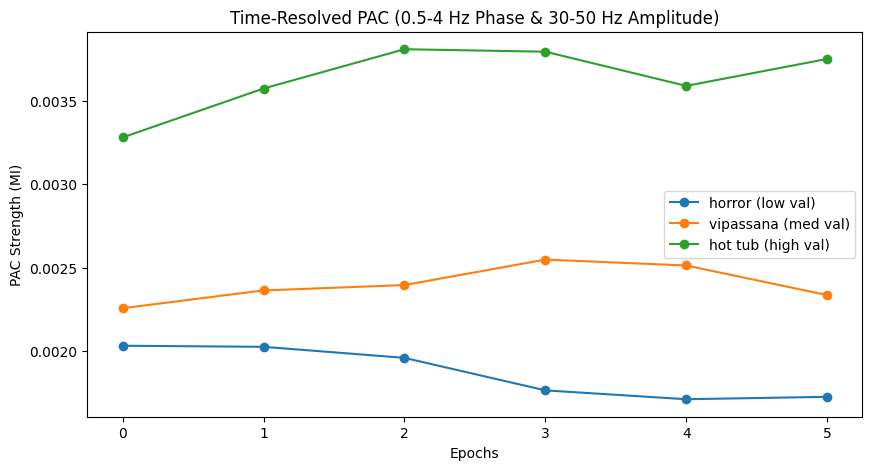

In [ ]:
ucsf_pac = compute_time_resolved_pac(
    ucsf_data, 
    fs=256, 
    window_length=30, 
    overlap=0.5, 
    freq_range_phase=(0.5,4), 
    freq_range_amplitude=(30, 50), 
    num_bins=18, 
    smooth_window=8, 
    zscore_threshold=2
)


In [24]:
ucsf_stats = compute_effect_sizes(ucsf_pac, name="UCSF Data")


Ucsf data Statistical Results:



,Comparison,Cohen's d,Rank-Biserial r,Mann-Whitney p-value
0,horror (low val) vs vipassana (med val),0.181231,-0.102210,7.141818e-02
1,horror (low val) vs hot tub (high val),-0.634993,0.310697,4.228970e-08
2,vipassana (med val) vs hot tub (high val),-0.760944,0.383783,1.284060e-11


# Compute Sample/Approximate Entropy

In [25]:
samp_en = compute_sample_entropy(ucsf_data,fs=256, window_size=1000)  
#print(samp_en)
samp_en_avg = compute_average_entropy(samp_en, entropy_type="Sample")
print(samp_en_avg)

  Participant                State  Mean_Entropy  SEM_Entropy
0     Dataset     horror (low val)      1.181788     0.006988
1     Dataset   hot tub (high val)      0.482243     0.022410
2     Dataset  vipassana (med val)      1.132473     0.005397


# Multi Scale Entropy (MSE) Using SampEn

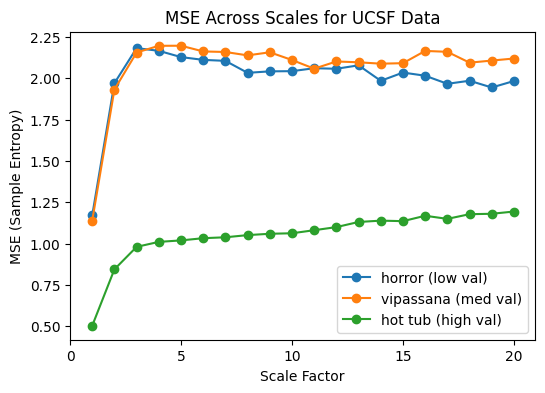

In [ ]:
# # Original MSE function 

def compute_sampen_single(signal, m=2, r=0.2):
    """
    Computes Sample Entropy (SampEn) for a single coarse-grained signal.
    
    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - m (int): Embedding dimension.
    - r (float): Tolerance as a fraction of signal standard deviation.

    Returns:
    - float: Sample Entropy value.
    """
    N = len(signal)
    if N < m + 1:  # Ensure the signal is long enough
        return np.nan
    r *= np.std(signal)  # Convert tolerance to absolute scale

    def _phi(m):
        templates = np.lib.stride_tricks.sliding_window_view(signal, window_shape=m)
        if templates.shape[0] < 2:
            return np.nan  # Avoid issues with very short segments
        dist_matrix = cdist(templates, templates, metric='chebyshev')
        count = np.sum(dist_matrix < r, axis=1) - 1  # Exclude self matches
        return np.mean(count) / (N - m)

    phi_m = _phi(m)
    phi_m1 = _phi(m + 1)

    if np.isnan(phi_m) or np.isnan(phi_m1) or phi_m1 == 0:
        return np.nan  # Avoid division errors

    return -np.log(phi_m1 / phi_m)

def compute_mse(signal, max_scale=20):
    """
    Computes Multiscale Entropy (MSE) efficiently using SampEn across multiple scales.

    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - max_scale (int): Maximum scale factor for coarse-graining.

    Returns:
    - Dict containing SampEn values at each scale.
    """
    mse_results = {}

    for scale in range(1, max_scale + 1):
        if len(signal) < scale:
            mse_results[f"Scale {scale}"] = np.nan  # Skip if scale is too large
            continue
        coarse_signal = np.mean(signal[:len(signal) - len(signal) % scale].reshape(-1, scale), axis=1)
        
        if len(coarse_signal) > 10:  # Ensure enough data points
            mse_results[f"Scale {scale}"] = compute_sampen_single(coarse_signal)
        else:
            mse_results[f"Scale {scale}"] = np.nan  # Not enough data for computation

    return mse_results

def compute_mse_all(data, max_scale=20):
    """
    Computes Multiscale Entropy (MSE) for EEG signals across different conditions.

    Parameters:
    - data (dict): Dictionary where keys are conditions (e.g., horror, vipassana, hot tub)
                   and values are NumPy arrays of EEG signals.
    - max_scale (int): Maximum scale factor for coarse-graining.

    Returns:
    - DataFrame: MSE values for each condition and scale.
    """
    results = []

    for condition, signal in data.items():  # Iterate through conditions
        mse_values = compute_mse(signal, max_scale)
        
        for scale, mse_value in mse_values.items():
            results.append({
                "Condition": condition,
                "Scale": int(scale.split(" ")[1]),  # Convert "Scale X" to integer X
                "MSE": mse_value
            })

    return pd.DataFrame(results)

def plot_mse_per_state(mse_df):
    """
    Plots MSE trends across scale factors for each condition.

    Parameters:
    - mse_df (DataFrame): DataFrame containing 'Condition', 'Scale', and 'MSE'.
    """
    unique_conditions = mse_df["Condition"].unique()

    fig, ax = plt.subplots(figsize=(6,4))
    
    for condition in unique_conditions:
        subset = mse_df[mse_df["Condition"] == condition]

        ax.plot(subset["Scale"], subset["MSE"], marker="o", label=condition)
    ax.set(xlabel="Scale Factor", ylabel="MSE (Sample Entropy)", title="MSE Across Scales for UCSF Data")
    ax.set(xticks=np.arange(0,21,5))
    ax.legend()

    plt.show()

# Compute MSE on UCSF dataset
mse_ucsf_df = compute_mse_all(ucsf_data, max_scale=20)

# Plot results
plot_mse_per_state(mse_ucsf_df)

In [ ]:
# # MSE with modifications to coarse graining

def coarse_graining(signal, scale_factor, step_size=1):
    """
    Performs coarse-graining on the input signal with a step size to reduce computation.
    
    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - scale_factor (int): Scale factor for coarse-graining.
    - step_size (int): Step size for selecting segments, reducing computational load.
    
    Returns:
    - Coarse-grained signal (array).
    """
    N = len(signal)
    if scale_factor > N:
        return None  # Avoid cases where scale factor is larger than the signal length
    
    coarse_grained_signal = np.array([
        np.mean(signal[i:i+scale_factor]) for i in range(0, N - scale_factor + 1, step_size)
    ])
    
    return coarse_grained_signal

def compute_sampen_single(signal, m=2, r=0.2):
    """
    Computes Sample Entropy (SampEn) for a single coarse-grained signal.
    
    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - m (int): Embedding dimension.
    - r (float): Tolerance as a fraction of signal standard deviation.

    Returns:
    - float: Sample Entropy value.
    """
    N = len(signal)
    if N < m + 1:  # Ensure the signal is long enough
        return np.nan
    r *= np.std(signal)  # Convert tolerance to absolute scale

    def _phi(m):
        templates = np.lib.stride_tricks.sliding_window_view(signal, window_shape=m)
        if templates.shape[0] < 2:
            return np.nan  # Avoid issues with very short segments
        dist_matrix = cdist(templates, templates, metric='chebyshev')
        count = np.sum(dist_matrix < r, axis=1) - 1  # Exclude self matches
        return np.mean(count) / (N - m)

    phi_m = _phi(m)
    phi_m1 = _phi(m + 1)

    if np.isnan(phi_m) or np.isnan(phi_m1) or phi_m1 == 0:
        return np.nan  # Avoid division errors

    return -np.log(phi_m1 / phi_m)

def compute_mse(signal, max_scale=20, step_size=5):
    """
    Computes Multiscale Entropy (MSE) efficiently using SampEn across multiple scales.

    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - max_scale (int): Maximum scale factor for coarse-graining.
    - step_size (int): Step size for selecting samples in coarse-graining.

    Returns:
    - Dict containing SampEn values at each scale.
    """
    mse_results = {}

    for scale in range(1, max_scale + 1):
        coarse_signal = coarse_graining(signal, scale, step_size)
        
        if coarse_signal is not None and len(coarse_signal) > 10:
            mse_results[f"Scale {scale}"] = compute_sampen_single(coarse_signal)  # <-- Fix applied here
        else:
            mse_results[f"Scale {scale}"] = np.nan
    
    return mse_results

def compute_mse_all(data, max_scale=20, step_size=5):
    """
    Computes Multiscale Entropy (MSE) for EEG signals across different conditions with reduced computational load.

    Parameters:
    - data (dict): Dictionary where keys are conditions (e.g., horror, vipassana, hot tub)
                   and values are NumPy arrays of EEG signals.
    - max_scale (int): Maximum scale factor for coarse-graining.
    - step_size (int): Step size for reducing computational complexity.

    Returns:
    - DataFrame: MSE values for each condition and scale.
    """
    results = []

    for condition, signal in data.items():
        mse_values = compute_mse(signal, max_scale, step_size)
        
        for scale, mse_value in mse_values.items():
            results.append({
                "Condition": condition,
                "Scale": int(scale.split(" ")[1]),  # Convert "Scale X" to integer X
                "MSE": mse_value
            })

    return pd.DataFrame(results)

def plot_mse_per_state(mse_df):
    """
    Plots MSE trends across scale factors for each condition.

    Parameters:
    - mse_df (DataFrame): DataFrame containing 'Condition', 'Scale', and 'MSE'.
    """
    unique_conditions = mse_df["Condition"].unique()
    
    for condition in unique_conditions:
        subset = mse_df[mse_df["Condition"] == condition]

        plt.figure(figsize=(8, 5))
        plt.plot(subset["Scale"], subset["MSE"], marker="o", label=condition)

        plt.xlabel("Scale Factor")
        plt.ylabel("MSE (Sample Entropy)")
        plt.title(f"MSE Across Scales for {condition}")
        plt.legend()
        plt.grid(True)
        plt.show()

# def plot_mse_per_state(mse_df):
#     """
#     Plots MSE trends across scale factors for each condition.

#     Parameters:
#     - mse_df (DataFrame): DataFrame containing 'Condition', 'Scale', and 'MSE'.
#     """
#     unique_conditions = mse_df["Condition"].unique()

#     fig, ax = plt.subplots(figsize=(6,4))
    
#     for condition in unique_conditions:
#         subset = mse_df[mse_df["Condition"] == condition]

#         ax.plot(subset["Scale"], subset["MSE"], marker="o", label=condition)
#     ax.set(xlabel="Scale Factor", ylabel="MSE (Sample Entropy)", title="MSE Across Scales for UCSF Data")
#     ax.set(xticks=np.arange(0,21,5))
#     ax.legend()

#     plt.show()

# Compute MSE on UCSF dataset
mse_ucsf_df = compute_mse_all(ucsf_data, max_scale=20, step_size=5)

# Plot results
plot_mse_per_state(mse_ucsf_df)

In [ ]:
# # Original MSE function without coarse graining but with down sampling from 256 Hz to 128 Hz 

def compute_sampen_single(signal, m=2, r=0.2):
    """
    Computes Sample Entropy (SampEn) for a single coarse-grained signal.
    
    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - m (int): Embedding dimension.
    - r (float): Tolerance as a fraction of signal standard deviation.

    Returns:
    - float: Sample Entropy value.
    """
    N = len(signal)
    if N < m + 1:  # Ensure the signal is long enough
        return np.nan
    r *= np.std(signal)  # Convert tolerance to absolute scale

    def _phi(m):
        templates = np.lib.stride_tricks.sliding_window_view(signal, window_shape=m)
        if templates.shape[0] < 2:
            return np.nan  # Avoid issues with very short segments
        dist_matrix = cdist(templates, templates, metric='chebyshev')
        count = np.sum(dist_matrix < r, axis=1) - 1  # Exclude self matches
        return np.mean(count) / (N - m)

    phi_m = _phi(m)
    phi_m1 = _phi(m + 1)

    if np.isnan(phi_m) or np.isnan(phi_m1) or phi_m1 == 0:
        return np.nan  # Avoid division errors

    return -np.log(phi_m1 / phi_m)

def compute_mse(signal, max_scale=20):
    """
    Computes Multiscale Entropy (MSE) efficiently using SampEn across multiple scales.

    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - max_scale (int): Maximum scale factor for coarse-graining.

    Returns:
    - Dict containing SampEn values at each scale.
    """
    mse_results = {}

    for scale in range(1, max_scale + 1):
        if len(signal) < scale:
            mse_results[f"Scale {scale}"] = np.nan  # Skip if scale is too large
            continue
        coarse_signal = np.mean(signal[:len(signal) - len(signal) % scale].reshape(-1, scale), axis=1)
        
        if len(coarse_signal) > 10:  # Ensure enough data points
            mse_results[f"Scale {scale}"] = compute_sampen_single(coarse_signal)
        else:
            mse_results[f"Scale {scale}"] = np.nan  # Not enough data for computation

    return mse_results

def compute_mse_all(data, max_scale=20):
    """
    Computes Multiscale Entropy (MSE) for EEG signals across different conditions.

    Parameters:
    - data (dict): Dictionary where keys are conditions (e.g., horror, vipassana, hot tub)
                   and values are NumPy arrays of EEG signals.
    - max_scale (int): Maximum scale factor for coarse-graining.

    Returns:
    - DataFrame: MSE values for each condition and scale.
    """
    results = []

    for condition, signal in data.items():  # Iterate through conditions
        mse_values = compute_mse(signal, max_scale)
        
        for scale, mse_value in mse_values.items():
            results.append({
                "Condition": condition,
                "Scale": int(scale.split(" ")[1]),  # Convert "Scale X" to integer X
                "MSE": mse_value
            })

    return pd.DataFrame(results)

# def plot_mse_per_state(mse_df):
#     """
#     Plots MSE trends across scale factors for each condition.

#     Parameters:
#     - mse_df (DataFrame): DataFrame containing 'Condition', 'Scale', and 'MSE'.
#     """
#     unique_conditions = mse_df["Condition"].unique()

#     fig, ax = plt.subplots(figsize=(6,4))
    
#     for condition in unique_conditions:
#         subset = mse_df[mse_df["Condition"] == condition]

#         ax.plot(subset["Scale"], subset["MSE"], marker="o", label=condition)
#     ax.set(xlabel="Scale Factor", ylabel="MSE (Sample Entropy)", title="MSE Across Scales for UCSF Data")
#     ax.set(xticks=np.arange(0,21,5))
#     ax.legend()

#     plt.show()

def plot_mse_per_state(mse_df):
    """
    Plots MSE trends across scale factors for each condition.

    Parameters:
    - mse_df (DataFrame): DataFrame containing 'Condition', 'Scale', and 'MSE'.
    """
    unique_conditions = mse_df["Condition"].unique()
    
    for condition in unique_conditions:
        subset = mse_df[mse_df["Condition"] == condition]

        plt.figure(figsize=(8, 5))
        plt.plot(subset["Scale"], subset["MSE"], marker="o", label=condition)

        plt.xlabel("Scale Factor")
        plt.ylabel("MSE (Sample Entropy)")
        plt.title(f"MSE Across Scales for {condition}")
        plt.legend()
        plt.grid(True)
        plt.show()

def downsample_signal(signal, original_fs=256, target_fs=128):
    """
    Downsamples the EEG signal using decimation.

    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - original_fs (int): Original sampling frequency.
    - target_fs (int): Target sampling frequency.

    Returns:
    - Downsampled signal (array).
    """
    downsample_factor = original_fs // target_fs  # Compute decimation factor
    return decimate(signal, downsample_factor, zero_phase=True)  # Apply downsampling

def downsample_data(data_dict, original_fs=256, target_fs=128):
    """
    Downsamples EEG signals in a dictionary format.

    Parameters:
    - data_dict (dict): Dictionary with condition names as keys and EEG signals as values.
    - original_fs (int): Original sampling frequency.
    - target_fs (int): Target sampling frequency.

    Returns:
    - Dictionary with downsampled EEG signals.
    """
    return {condition: downsample_signal(signal, original_fs, target_fs) for condition, signal in data_dict.items()}

# **Downsample UCSF EEG Data**
downsampled_ucsf_data = downsample_data(ucsf_data, original_fs=256, target_fs=128)

# Compute MSE on downsampled UCSF dataset
mse_ucsf_df = compute_mse_all(downsampled_ucsf_data, max_scale=20)

# Plot results
plot_mse_per_state(mse_ucsf_df)

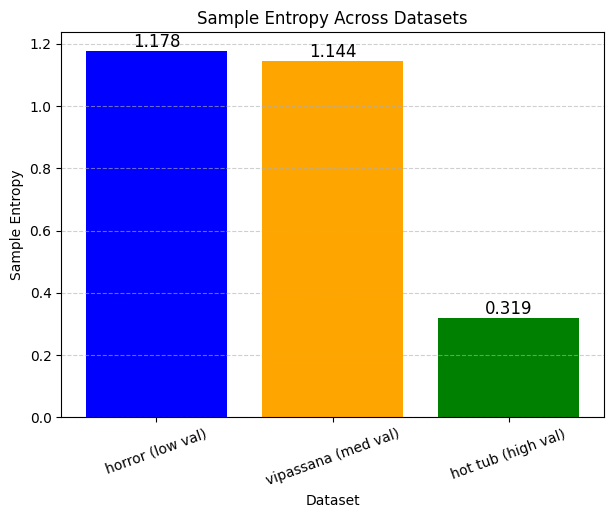

In [ ]:
# # SampleEn without time-windowed approach

# Function to compute Sample Entropy
def compute_sample_entropy(signal, m=2, r=0.2):
    """
    Computes Sample Entropy (SampEn) efficiently using vectorized operations.

    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - m (int): Embedding dimension (default = 2).
    - r (float): Tolerance as a fraction of signal standard deviation (default = 0.2).

    Returns:
    - float: Sample Entropy value.
    """
    N = len(signal)
    r *= np.std(signal)  # Convert tolerance to absolute scale

    def _phi(m):
        templates = np.array([signal[i:i+m] for i in range(N - m)])
        dist_matrix = cdist(templates, templates, metric='chebyshev') # Chebyshev distance
        count = np.sum(dist_matrix < r, axis=1) - 1  # Exclude self matches
        return np.mean(count) / (N - m)

    phi_m = _phi(m)
    phi_m1 = _phi(m + 1)

    if phi_m == 0 or phi_m1 == 0:
        return np.nan  # Avoid division by zero

    return -np.log(phi_m1 / phi_m)

# Function to compute Sample Entropy for each dataset
def compute_sample_entropy_all(participant_data):
    """
    Computes Sample Entropy (SampEn) for each dataset.

    Parameters:
    - participant_data (dict): Dictionary where keys are dataset names (e.g., Horror, Vipassana)
                               and values are EEG signals.

    Returns:
    - DataFrame: Sample Entropy values for each dataset.
    """
    results = []
    
    for dataset_name, signal in participant_data.items():
        if len(signal) < 10:  # Ensure we have enough data points
            samp_entropy = np.nan
        else:
            samp_entropy = compute_sample_entropy(signal)
        
        results.append({"Dataset": dataset_name, "Sample Entropy": samp_entropy})

    return pd.DataFrame(results)


# Compute Sample Entropy for all datasets
samp_entropy_df = compute_sample_entropy_all(ucsf_data)

# Function to plot Sample Entropy as a bar graph
def plot_samp_entropy(samp_entropy_df):
    """
    Plots Sample Entropy for each dataset in a bar graph with values displayed on top.

    Parameters:
    - samp_entropy_df (DataFrame): DataFrame containing dataset names and corresponding Sample Entropy values.
    """
    plt.figure(figsize=(7, 5))
    
    bars = plt.bar(samp_entropy_df["Dataset"], samp_entropy_df["Sample Entropy"], color=["blue","orange","green"])

    # Add values on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.3f}", ha="center", va="bottom", fontsize=12)

    plt.xlabel("Dataset")
    plt.ylabel("Sample Entropy")
    plt.title("Sample Entropy Across Datasets")
    plt.xticks(rotation=20)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

# Plot the results
plot_samp_entropy(samp_entropy_df)